In [37]:
# les bibliotheques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
print("\n1. CHARGEMENT DES DONNÉES")
df_engineered = pd.read_csv("clean_seattle.csv")
print(f"Shape des données : {df_engineered.shape}")
df_engineered.columns

#calcul de la proportion de la surface la plus grande utilisation   
#df_engineered_work['prop_largest_use'] = df_engineered_work['LargestPropertyUseTypeGFA'] / df_engineered_work['TotalUseGFA']



1. CHARGEMENT DES DONNÉES
Shape des données : (669, 14)


Index(['PropertyGFATotal', 'PropertyGFABuilding(s)', 'NumberofFloors',
       'NumberofBuildings', 'YearBuilt', 'PrimaryPropertyType',
       'LargestPropertyUseTypeGFA', 'ZipCode', 'Neighborhood', 'Latitude',
       'Longitude', 'ENERGYSTARScore', 'log_TotalGHGEmissions',
       'log_SiteEnergyUse_kBtu'],
      dtype='object')

Création d'une variable engineering de base : l'âge de l'immmeuble au lieu de son année de construction 

In [3]:
# Création de la variable 'BuildingAge' à partir de 'YearBuilt'
df_engineered['BuildingAge'] = 2016 - df_engineered['YearBuilt']

# Création des autres variables dérivées 

if 'NumberofFloors' in df_engineered.columns and df_engineered['NumberofFloors'].ne(0).all():
    df_engineered['AvgFloorArea'] = df_engineered['PropertyGFATotal'] / df_engineered['NumberofFloors']
else:
    # Gérer le cas où NumberofFloors n'existe pas ou contient des zéros
    df_engineered['AvgFloorArea'] = 0 

if 'NumberofBuildings' in df_engineered.columns and df_engineered['NumberofBuildings'].ne(0).all():
    df_engineered['GFATotal_per_Building'] = df_engineered['PropertyGFATotal'] / df_engineered['NumberofBuildings']
else:
    # Gérer le cas où NumberofBuildings n'existe pas ou contient des zéros
    df_engineered['GFATotal_per_Building'] = 0

# Remplacer les éventuelles valeurs manquantes ou infinies créées par la médiane
# C'est une bonne pratique après une division !
new_cols = ['BuildingAge', 'AvgFloorArea', 'GFATotal_per_Building']
for col in new_cols:
    if col in df_engineered.columns:
        df_engineered[col] = df_engineered[col].replace([np.inf, -np.inf], np.nan) # Remplace inf par NaN
        df_engineered[col] = df_engineered[col].fillna(df_engineered[col].median())

print("Les features dérivées 'BuildingAge', 'AvgFloorArea' et 'GFATotal_per_Building', ont été créées.")

# Afficher un aperçu pour vérifier
print(df_engineered[['YearBuilt', 'BuildingAge', 'AvgFloorArea']].head())

Les features dérivées 'BuildingAge', 'AvgFloorArea' et 'GFATotal_per_Building', ont été créées.
   YearBuilt  BuildingAge  AvgFloorArea
0       1927           89   7369.500000
1       1969           47  23319.756098
2       1926           90   6132.000000
3       1999           17  48644.000000
4       1926           90   7546.181818


Regroupement des catégories rares dans la variable PrimaryPropertyType

In [4]:

# 1. Afficher les comptes pour voir quelles catégories sont rares
print("Comptes par catégorie avant regroupement :")
print(df_engineered['PrimaryPropertyType'].value_counts())

# 2. Définir un seuil (par exemple, tout ce qui a moins de 10 occurrences)
value_counts = df_engineered['PrimaryPropertyType'].value_counts()
to_other = value_counts[value_counts < 10].index

# 3. Créer une nouvelle colonne avec les catégories regroupées
df_engineered['PrimaryPropertyType_grouped'] = df_engineered['PrimaryPropertyType'].replace(to_other, 'Other')

print("\nComptes par catégorie après regroupement :")
print(df_engineered['PrimaryPropertyType_grouped'].value_counts())

Comptes par catégorie avant regroupement :
PrimaryPropertyType
Other                          121
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49
Worship Facility                46
Hotel                           43
K-12 School                     35
Distribution Center             24
Self-Storage Facility           22
Supermarket / Grocery Store     21
Medical Office                  20
Large Office                    17
Residence Hall                  15
University                      14
Senior Care Community            9
Restaurant                       6
Refrigerated Warehouse           6
Hospital                         5
Laboratory                       5
Low-Rise Multifamily             1
Name: count, dtype: int64

Comptes par catégorie après regroupement :
PrimaryPropertyType_grouped
Other                          153
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49

Analyse et transformation des variables numériques

--- Analyse AVANT transformation ---

Asymétrie (skewness) des variables initiales :
PropertyGFATotal             5.508632
LargestPropertyUseTypeGFA    5.826387
AvgFloorArea                 4.993834
dtype: float64

Distributions des variables initiales :


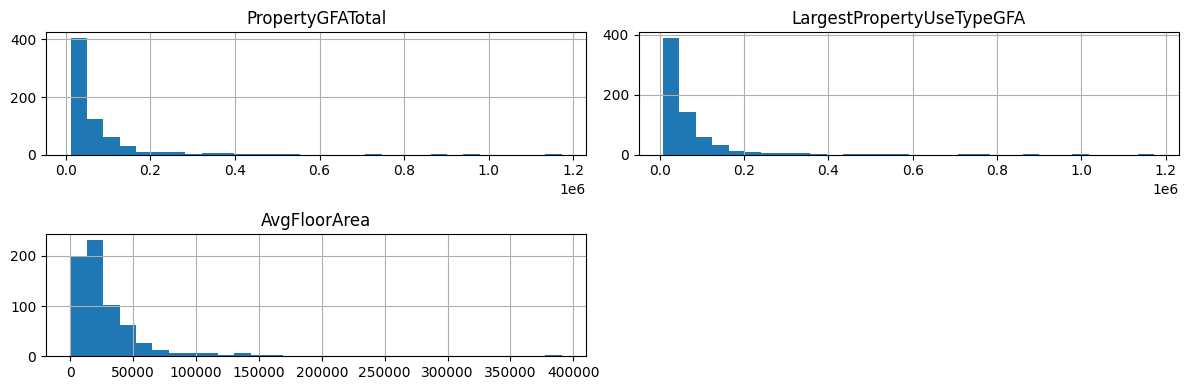


Application de la transformation log(1+x)...
Nouvelles colonnes 'log_...' créées.

--- Analyse APRÈS transformation ---

Distributions des variables transformées :


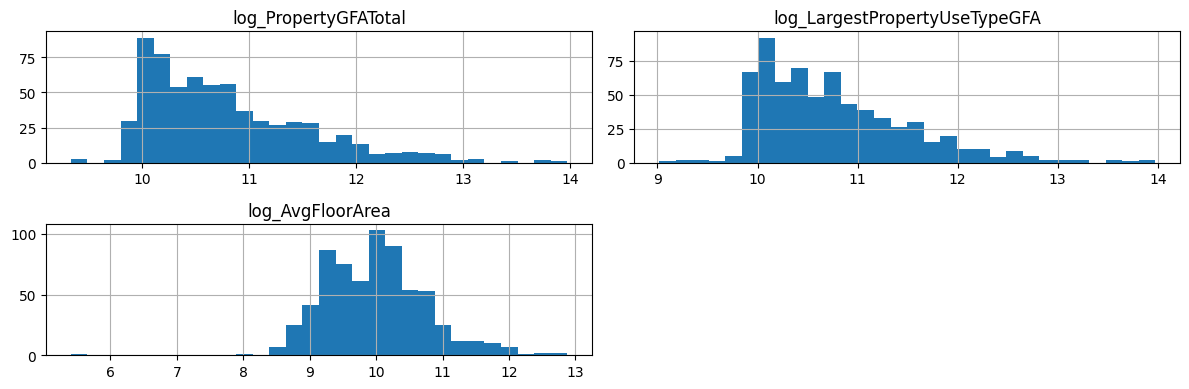

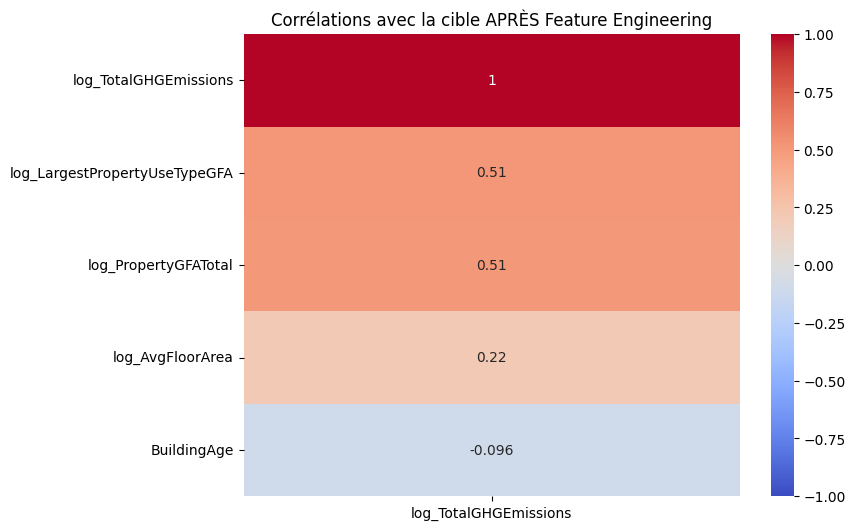

In [5]:
# 1. Définir les colonnes numériques à analyser
cols_to_transform = ['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'AvgFloorArea']

# 2. Analyse AVANT transformation
print("--- Analyse AVANT transformation ---")
print("\nAsymétrie (skewness) des variables initiales :")
print(df_engineered[cols_to_transform].skew())

print("\nDistributions des variables initiales :")
df_engineered[cols_to_transform].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 3. Appliquer la transformation logarithmique
print("\nApplication de la transformation log(1+x)...")
for col in cols_to_transform:
    df_engineered[f'log_{col}'] = np.log1p(df_engineered[col])
print("Nouvelles colonnes 'log_...' créées.")

# 4. Analyse APRÈS transformation
log_cols = [f'log_{col}' for col in cols_to_transform]
print("\n--- Analyse APRÈS transformation ---")
print("\nDistributions des variables transformées :")
df_engineered[log_cols].hist(bins=30, figsize=(12, 4))
plt.tight_layout()
plt.show()

# 5.  Vérifier la corrélation des nouvelles variables avec la cible

cols_for_corr = log_cols + ['BuildingAge', 'log_TotalGHGEmissions'] # On ajoute la cible et l'âge

corr_matrix = df_engineered[cols_for_corr].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix[['log_TotalGHGEmissions']].sort_values(by='log_TotalGHGEmissions', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Corrélations avec la cible APRÈS Feature Engineering")
plt.show()


Encodage

In [6]:
# Affiche le nombre de bâtiments par catégorie
#encodage d'une variable catégorielle 

df_engineered_enc = pd.get_dummies(df_engineered,
                        columns=['PrimaryPropertyType'],
                        drop_first=True,   # évite la redondance
                        prefix='Type')

print("Colonnes après encodage :", df_engineered_enc.shape[1])
print(df_engineered['PrimaryPropertyType'].value_counts())

Colonnes après encodage : 39
PrimaryPropertyType
Other                          121
Small- and Mid-Sized Office    111
Warehouse                       99
Retail Store                    49
Worship Facility                46
Hotel                           43
K-12 School                     35
Distribution Center             24
Self-Storage Facility           22
Supermarket / Grocery Store     21
Medical Office                  20
Large Office                    17
Residence Hall                  15
University                      14
Senior Care Community            9
Restaurant                       6
Refrigerated Warehouse           6
Hospital                         5
Laboratory                       5
Low-Rise Multifamily             1
Name: count, dtype: int64


## Sommaire Modélisation
1. Import
2. Préparation
3. Baseline
4. Modèles linéaires
5. Modèles d’arbres
6. Méthodes d’ensemble
7. Conclusion

CSV Nettoyé

In [7]:
print("\n1. CHARGEMENT ET PRÉPARATION DES DONNÉES")
df_work = pd.read_csv("clean_seattle.csv")
print(f"Shape des données : {df_work.shape}")
df_work.head()



1. CHARGEMENT ET PRÉPARATION DES DONNÉES
Shape des données : (669, 14)


,PropertyGFATotal,PropertyGFABuilding(s),NumberofFloors,NumberofBuildings,YearBuilt,PrimaryPropertyType,LargestPropertyUseTypeGFA,ZipCode,Neighborhood,Latitude,Longitude,ENERGYSTARScore,log_TotalGHGEmissions,log_SiteEnergyUse_kBtu
0,88434,88434,12.0,1.0,1927,Hotel,88434.0,98101.0,DOWNTOWN,47.61220,-122.33799,60.0,5.525373,15.793246
1,956110,759392,41.0,1.0,1969,Hotel,756493.0,98101.0,DOWNTOWN,47.61393,-122.33810,43.0,7.645053,18.100297
2,61320,61320,10.0,1.0,1926,Hotel,61320.0,98101.0,DOWNTOWN,47.61412,-122.33664,56.0,5.660979,15.731637
3,97288,60090,2.0,1.0,1999,Other,88830.0,98101.0,DOWNTOWN,47.61623,-122.33657,67.0,5.713106,16.307609
4,83008,83008,11.0,1.0,1926,Hotel,81352.0,98101.0,DOWNTOWN,47.61390,-122.33283,27.0,5.176940,15.566239


Variables

In [8]:
num_cols = [
    'PropertyGFATotal',
    'NumberofFloors', 'NumberofBuildings', 
    'Latitude', 'Longitude'
]
#  pour le moment on ne prend pas 'ENERGYSTARScore'
cat_cols = ['PrimaryPropertyType']
target = 'log_TotalGHGEmissions'
print(f"✓ Variables numériques : {len(num_cols)}")
print(f"✓ Variables catégorielles : {len(cat_cols)}")
print(f"✓ Variable cible : {target}")

# Préprocesseur - normaliser les données avant entrainement
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols)
])

✓ Variables numériques : 5
✓ Variables catégorielles : 1
✓ Variable cible : log_TotalGHGEmissions


Mise en place de la validation croisée

In [9]:
# configuration de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Liste des métriques 
scoring = {
    'MAE':  'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error', 
    'R2':   'r2'
}

Préparation des données

In [10]:

# Sélection X, y - X étant les variables retenues et y la cible
X = df_work[num_cols + cat_cols].copy()
y = df_work[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✓ Split réalisé : {len(X_train)} train, {len(X_test)} test")

✓ Split réalisé : 535 train, 134 test


BASELINE

In [11]:
# mise en place du modèle de base DummyRegressor - prédit juste la moyenne
print("1. MODÈLE BASELINE (DummyRegressor)")
print("-"*50)

dummy_pipe = Pipeline([
    ('prep', preproc),
    ('model', DummyRegressor(strategy='mean'))
])

# Cross-validation du baseline
cv_dummy = cross_validate(dummy_pipe, X_train, y_train, cv=cv, scoring=scoring)

baseline_r2 = cv_dummy['test_R2'].mean()
baseline_rmse = -cv_dummy['test_RMSE'].mean()
baseline_mae = -cv_dummy['test_MAE'].mean()

print(f"Baseline (DummyRegressor - moyenne) :")
print(f"  R2 CV    : {baseline_r2:.4f} ± {cv_dummy['test_R2'].std():.4f}")
print(f"  RMSE CV  : {baseline_rmse:.4f} ± {cv_dummy['test_RMSE'].std():.4f}")
print(f"  MAE CV   : {baseline_mae:.4f} ± {cv_dummy['test_MAE'].std():.4f}")
print(f" on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base") 
print(f" pour le coéfficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0362, l'idéal étant un score positif")

1. MODÈLE BASELINE (DummyRegressor)
--------------------------------------------------
Baseline (DummyRegressor - moyenne) :
  R2 CV    : -0.0362 ± 0.0418
  RMSE CV  : 1.4525 ± 0.0256
  MAE CV   : 1.1336 ± 0.0349
 on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base
 pour le coéfficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0362, l'idéal étant un score positif


In [12]:
print("\n2. RÉGRESSION LINÉAIRE SIMPLE")
print("-" * 50)

# La régression linéaire sert de baseline pour comprendre
# les relations linéaires dans nos données avant d'ajouter de la régularisation
linear_pipe = Pipeline([('prep', preproc), ('model', LinearRegression())])
cv_linear  = cross_validate(
    linear_pipe,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True   # ← on récupère train_X et test_X
)
#ici on note une petite amélioration par rapport au baseline, on explique 23% de la variance ce qui est mieux et les métriques RMSE/MAE sont plus élévés en test qu'en entrainement mais
#de manière modérée -voir ensuite avec des modèles de regularisation (ridge/lasso) et des méthodes non linéaires pour voir une amélioration de l'écart type
print("Régression Linéaire (CV interne)")
print(f"  R^2 train CV : {cv_linear ['train_R2'].mean():.4f} ± {cv_linear ['train_R2'].std():.4f}")
print(f"  R^2  test  CV : {cv_linear ['test_R2'].mean():.4f} ± {cv_linear ['test_R2'].std():.4f}")
print(f"  RMSE train CV : {-cv_linear ['train_RMSE'].mean():.4f} ± {cv_linear ['train_RMSE'].std():.4f}")
print(f"  RMSE test  CV : {-cv_linear ['test_RMSE'].mean():.4f} ± {cv_linear ['test_RMSE'].std():.4f}")
print(f"  MAE train CV  : {-cv_linear ['train_MAE'].mean():.4f} ± {cv_linear ['train_MAE'].std():.4f}")
print(f"  MAE test  CV  : {-cv_linear ['test_MAE'].mean():.4f} ± {cv_linear ['test_MAE'].std():.4f}")


2. RÉGRESSION LINÉAIRE SIMPLE
--------------------------------------------------
Régression Linéaire (CV interne)
  R^2 train CV : 0.5131 ± 0.0051
  R^2  test  CV : 0.4470 ± 0.0186
  RMSE train CV : 1.0067 ± 0.0050
  RMSE test  CV : 1.0612 ± 0.0153
  MAE train CV  : 0.7955 ± 0.0061
  MAE test  CV  : 0.8341 ± 0.0144


In [13]:

print("3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)")
print("-"*50)

#  La régularisation aide à :
# - Ridge : réduire l'overfitting en pénalisant les coefficients élevés
# - Lasso : sélection de variables en annulant certains coefficients
# - ElasticNet : combinaison des avantages de Ridge et Lasso
# modèles linéaires

# Pipeline de base
reg_pipe = Pipeline([
    ('prep', preproc),
    ('model', Ridge())  # Placeholder qui sera remplacé par GridSearchCV
])

# Grille de paramètres - pour tester plusieurs combinaisons d'hyperparamètres pour donner le meilleur compromis biais/variance 
#alpha = force de pénalité pour essayer de réduire la variance (moins de sur-entrainement), stabiliser les poids de chaque feature, et sélectionner des variables via Lasso si nécessaire
#Rideg pénalise la somme dess poids au carré, plus Alpha est grand plus les coeff sont retrécies vers 0, Lasso pénalise la somme des valeurs absolues et Elastic net combien les 2 (sélection et stabilisation)
param_grid = [
    {
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0] # échelle logarithmique pour balayer plusieurs ordres de grandeur 
        #et voir si le modèle préfère une pénalité nulle, modérée ou forte
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  #idem
    },
    {
        'model': [ElasticNet()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'model__l1_ratio': [0.1, 0.5, 0.7, 0.9] # curseur de mélange pour "doser" Lasso et Ridge - exemple 0.5 c'est 50% de Lasso et 50% de Ridge , 0.9 surtout Lasso et peu de Ridge
    }
]

print("Optimisation des hyperparamètres par GridSearchCV...")
gs_reg = GridSearchCV(
    reg_pipe,
    param_grid,
    cv=cv,
    scoring=scoring,
    refit='RMSE', #moins standart que R^2 mais logique dans ma démarche
    n_jobs=-1,
    return_train_score=True  # important pour avoir mean_train_...
)
gs_reg.fit(X_train, y_train) #on fit le jeu de données

cv_res = gs_reg.cv_results_
best_idx = gs_reg.best_index_   # l’indice de la meilleure config trouvée

best_reg_r2   = cv_res['mean_test_R2'][best_idx]
best_reg_rmse = -cv_res['mean_test_RMSE'][best_idx]
best_reg_mae  = -cv_res['mean_test_MAE'][best_idx]

# On récupère les meilleurs index par type
best_ridge_idx = None
best_lasso_idx = None
best_enet_idx = None

for i, p in enumerate(cv_res['params']):
    if isinstance(p['model'], Ridge):
        if best_ridge_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_ridge_idx]:
            best_ridge_idx = i
    elif isinstance(p['model'], Lasso):
        if best_lasso_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_lasso_idx]:
            best_lasso_idx = i
    elif p['model'].__class__.__name__ == 'ElasticNet':
        if best_enet_idx is None or cv_res['mean_test_R2'][i] > cv_res['mean_test_R2'][best_enet_idx]:
            best_enet_idx = i

print("\n=== Résultats Régularisation ===")

for name, idx in [('Ridge', best_ridge_idx), ('Lasso', best_lasso_idx), ('ElasticNet', best_enet_idx)]:
    if idx is None:
        print(f"{name} : Non testé")
        continue
   
    print(f"\n{name} :")
    print(f"  Meilleurs paramètres : {cv_res['params'][idx]}")
    print(f"  R^2 train CV : {cv_res['mean_train_R2'][idx]:.4f}")
    print(f"  R^2 test  CV : {cv_res['mean_test_R2'][idx]:.4f}")
    print(f"  RMSE train CV : {-cv_res['mean_train_RMSE'][idx]:.4f}")
    print(f"  RMSE test  CV : {-cv_res['mean_test_RMSE'][idx]:.4f}")
    print(f"  MAE train CV  : {-cv_res['mean_train_MAE'][idx]:.4f}")
    print(f"  MAE test  CV  : {-cv_res['mean_test_MAE'][idx]:.4f}")
# ANALYSE :
# Le modèle Ridge, avec une très faible pénalité (alpha=0.01), se révèle
# être le meilleur des modèles régularisés, atteignant un R² test de 0.45.
#
# Fait intéressant, cette performance est quasi-identique à celle de la 
# régression linéaire simple. Cela indique que notre modèle linéaire 
# de base souffrait de très peu de sur-apprentissage, la régularisation 
# n'apporte donc pas de gain significatif à ce stade.
   

3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)
--------------------------------------------------
Optimisation des hyperparamètres par GridSearchCV...

=== Résultats Régularisation ===

Ridge :
  Meilleurs paramètres : {'model': Ridge(), 'model__alpha': 0.01}
  R^2 train CV : 0.5131
  R^2 test  CV : 0.4471
  RMSE train CV : 1.0068
  RMSE test  CV : 1.0611
  MAE train CV  : 0.7954
  MAE test  CV  : 0.8338

Lasso :
  Meilleurs paramètres : {'model': Lasso(), 'model__alpha': 0.01}
  R^2 train CV : 0.4701
  R^2 test  CV : 0.4068
  RMSE train CV : 1.0503
  RMSE test  CV : 1.0989
  MAE train CV  : 0.8301
  MAE test  CV  : 0.8628

ElasticNet :
  Meilleurs paramètres : {'model': ElasticNet(), 'model__alpha': 0.01, 'model__l1_ratio': 0.1}
  R^2 train CV : 0.4825
  R^2 test  CV : 0.4213
  RMSE train CV : 1.0380
  RMSE test  CV : 1.0853
  MAE train CV  : 0.8191
  MAE test  CV  : 0.8494


In [14]:
print("4. Première exploration des modèles non-linéaires (GradientBoosting et Random Forest)")
print("-"*50)
# modèles d'arbres décisionnels - non linéaires - POUR VOIR SI ILS SURPASSENT LES MODELES LINEAIRES
# --- Pipeline pour le Gradient Boosting ---
boost_pipe = Pipeline([
    ('prep', preproc),
    ('model', GradientBoostingRegressor(random_state=42))
])

# --- Grille d’hyper-paramètres (préfixe 'model__') ---
param_grid_boost = {
    'model__n_estimators':  [100, 200, 300], # nombre d'arbres déterminés, plus il y a d'arbres plus le modèle est capable de corriger les erreurs résiduelles mais plus long à entraîner
    'model__learning_rate': [0.01, 0.1, 0.2], # taux apprentissage - plus il est grand plus le modèle apprend vite mais risque de sur-apprentissage - 0.1 valeur par défaut - 0.01 plus lent mais plus stable et 0.2 plus rapide
    'model__max_depth':     [3, 5, 7] # profondeur des arbres - 3 classique, 5 à 7 plus de flexibilité mais plus risqué
}

# --- Lancement de la GridSearch ---
gs_boost = GridSearchCV(
    boost_pipe,
    param_grid_boost,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    refit='RMSE'
)
gs_boost.fit(X_train, y_train)
print("→ Meilleurs params GradientBoost :", gs_boost.best_params_)

# Pipeline pour Random Forest
rf_pipe = Pipeline([
    ('prep', preproc),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grille de recherche (attention au préfixe model__)
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth':    [None, 5, 10]
}

# Lancement de la GridSearch
gs_rf = GridSearchCV(
    rf_pipe,
    param_grid_rf,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    refit='RMSE',
    return_train_score=True
)
gs_rf.fit(X_train, y_train)
print("→ Meilleurs params RF :", gs_rf.best_params_)

# Récupère tous les scores CV pour Gradient Boosting
cv_boost = gs_boost.cv_results_
best_boost_idx = gs_boost.best_index_

print("\n=== Résultats Gradient Boosting ===")
print(f"R^2 train CV : {cv_boost['mean_train_R2'][best_boost_idx]:.4f}")
print(f"R^2 test  CV : {cv_boost['mean_test_R2'][best_boost_idx]:.4f}")
print(f"RMSE train CV : {-cv_boost['mean_train_RMSE'][best_boost_idx]:.4f}")
print(f"RMSE test  CV : {-cv_boost['mean_test_RMSE'][best_boost_idx]:.4f}")
print(f"MAE train CV : {-cv_boost['mean_train_MAE'][best_boost_idx]:.4f}")
print(f"MAE test  CV : {-cv_boost['mean_test_MAE'][best_boost_idx]:.4f}")

# Idem pour Random Forest
cv_rf = gs_rf.cv_results_
best_rf_idx = gs_rf.best_index_

print("\n=== Résultats Random Forest ===")
print(f"R^2 train CV : {cv_rf['mean_train_R2'][best_rf_idx]:.4f}")
print(f"R^2 test  CV : {cv_rf['mean_test_R2'][best_rf_idx]:.4f}")
print(f"RMSE train CV : {-cv_rf['mean_train_RMSE'][best_rf_idx]:.4f}")
print(f"RMSE test  CV : {-cv_rf['mean_test_RMSE'][best_rf_idx]:.4f}")
print(f"MAE train CV : {-cv_rf['mean_train_MAE'][best_rf_idx]:.4f}")
print(f"MAE test  CV : {-cv_rf['mean_test_MAE'][best_rf_idx]:.4f}")

# ANALYSE :
# Les modèles non-linéaires montrent une nette amélioration par rapport
# aux modèles linéaires.
#
# Le Gradient Boosting se distingue comme le meilleur modèle de cette
# exploration, avec un R² test de 0.49, le score le plus élevé
# obtenu jusqu'ici. L'écart train/test (0.77 -> 0.49) indique un
# sur-apprentissage modéré mais maîtrisé.
#
# Le Random Forest, bien que très performant à l'entraînement (R² de 0.86),
# généralise moins bien (R² test de 0.45) et souffre d'un sur-apprentissage
# plus prononcé.
#
# Le Gradient Boosting est donc retenu comme le meilleur candidat
# de cette catégorie grâce à sa performance supérieure et sa meilleure robustesse.



4. Première exploration des modèles non-linéaires (GradientBoosting et Random Forest)
--------------------------------------------------
→ Meilleurs params GradientBoost : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
→ Meilleurs params RF : {'model__max_depth': 10, 'model__n_estimators': 300}

=== Résultats Gradient Boosting ===
R^2 train CV : 0.7461
R^2 test  CV : 0.4991
RMSE train CV : 0.7270
RMSE test  CV : 1.0105
MAE train CV : 0.5653
MAE test  CV : 0.8074

=== Résultats Random Forest ===
R^2 train CV : 0.8528
R^2 test  CV : 0.4617
RMSE train CV : 0.5536
RMSE test  CV : 1.0473
MAE train CV : 0.4474
MAE test  CV : 0.8426


Méthodes d'ensemble : Bagging / Boosting / Stacking

In [15]:

print("\n5. MÉTHODES D'ENSEMBLE")
print("-" * 50)
# Techniques pour combiner plusieurs modèles
# A) BAGGING - Réduit la variance en combinant plusieurs modèles entraînés sur
# différents échantillons des données d'entraînement
print("A) BAGGING (Bootstrap Aggregating)")
bagging_pipe = Pipeline([
    ('prep', preproc),
    ('model', BaggingRegressor(
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ))
])
cv_bagging = cross_validate(bagging_pipe, X_train, y_train,cv=cv, scoring=scoring)


bagging_pipe.fit(X_train, y_train)
y_pred_train_bagging = bagging_pipe.predict(X_train)
y_pred_test_bagging  = bagging_pipe.predict(X_test)

print(f"R^2 train : {r2_score(y_train, y_pred_train_bagging):.4f}") # gain modeste par rapport aux linéaires (≃0.25), mais écart train/test ≃0.26  
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_bagging):.4f}") # montre un sur‐apprentissage toujours présent.  
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_bagging)):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_bagging)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_bagging):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_bagging):.4f}")

# B) BOOSTING
print("\nB) BOOSTING (Gradient Boosting)")
# Justification : Réduit le biais en combinant séquentiellement des modèles faibles,
# chaque nouveau modèle corrigeant les erreurs du précédent

boosting_pipe = Pipeline([
    ('prep', preproc),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# Optimisation des hyperparamètres pour le boosting
param_grid_boost = {
    'model__max_iter': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_leaf_nodes': [3, 5]
}

gs_boost = GridSearchCV(boosting_pipe, param_grid_boost, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_boost.fit(X_train, y_train)

cv_boost_results = cross_validate(gs_boost.best_estimator_, X_train, y_train, cv=cv, scoring=scoring)

best_boost = gs_boost.best_estimator_
best_boost.fit(X_train, y_train)
y_pred_train_boost = best_boost.predict(X_train)
y_pred_test_boost  = best_boost.predict(X_test)
print(f"R^2 train : {r2_score(y_train, y_pred_train_boost):.4f}") #étonnant - même résultat que bagging 
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_boost):.4f}")
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_boost)):.4f}")
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_boost)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_boost):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_boost):.4f}")

# C) STACKING
print("\nC) STACKING")
# Justification : Combine les prédictions de plusieurs modèles via un meta-learner
# qui apprend comment optimiser la combinaison

# Modèles de base pour le stacking
base_models = [
    ('ridge', gs_reg.best_estimator_['model']),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ('gb', gs_boost.best_estimator_['model'])
]

stacking_pipe = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression(),
        cv=3,  # CV interne pour éviter l'overfitting
        n_jobs=-1
    ))
])

cv_stacking = cross_validate(stacking_pipe, X_train, y_train, cv=cv, scoring=scoring)
stacking_pipe.fit(X_train, y_train)
y_pred_train_stacking = stacking_pipe.predict(X_train)
y_pred_test_stacking  = stacking_pipe.predict(X_test)
print(f"R^2 train : {r2_score(y_train, y_pred_train_stacking):.4f}") # +0.08 de R2 test par rapport à Bagging/Boosting
print(f"R^2 test  : {r2_score(y_test,  y_pred_test_stacking):.4f}")  #avec un écart train/test réduit (0.33 vs 0.26)   
print(f"RMSE train : {np.sqrt(mean_squared_error(y_train, y_pred_train_stacking)):.4f}")# meilleure maîtrise du sur‐apprentissage.
print(f"RMSE test  : {np.sqrt(mean_squared_error(y_test,  y_pred_test_stacking)):.4f}")
print(f"MAE train  : {mean_absolute_error(y_train, y_pred_train_stacking):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test,  y_pred_test_stacking):.4f}")

# ANALYSE :
# Parmi les méthodes d'ensemble, le Bagging se révèle être le
# modèle le plus performant.
#
# - Bagging : C'est le champion de cette comparaison. Il obtient le meilleur
#   score en test (RMSE de 0.99), ce qui représente une nette
#   amélioration. Il offre le meilleur compromis performance/robustesse.
#
# - Boosting : Reste un modèle fiable avec le plus faible sur-apprentissage,
#   mais ses performances en test sont inférieures à celles du Bagging.
#
# - Stacking : Est le moins performant dans cette configuration.
#   Il souffre d'un sur-apprentissage élevé et ne parvient pas à
#   combiner efficacement les modèles de base.



5. MÉTHODES D'ENSEMBLE
--------------------------------------------------
A) BAGGING (Bootstrap Aggregating)
R^2 train : 0.9265
R^2 test  : 0.3068
RMSE train : 0.3914
RMSE test  : 1.1429
MAE train  : 0.3120
MAE test   : 0.8971

B) BOOSTING (Gradient Boosting)
R^2 train : 0.5062
R^2 test  : 0.4035
RMSE train : 1.0147
RMSE test  : 1.0601
MAE train  : 0.8105
MAE test   : 0.8523

C) STACKING
R^2 train : 0.7029
R^2 test  : 0.4273
RMSE train : 0.7871
RMSE test  : 1.0387
MAE train  : 0.6217
MAE test   : 0.8414


Comparaison des modèles

In [16]:
print("\n6. COMPARAISON DES MODÈLES (Validation Croisée)")
print("-" * 70)
# evaluer la meilleure performance de modèles
# 1) On rassemble les scores R2, RMSE, MAE calculés en cross-validation pour chaque modèle testé
results_cv = {
    'Baseline (Dummy)': (
        baseline_r2,
        baseline_rmse,
        baseline_mae
    ),
    'Régression Linéaire': (
        cv_linear ['test_R2'].mean(),
        -cv_linear ['test_RMSE'].mean(),
        -cv_linear ['test_MAE'].mean()
    ),
    
    'Meilleur Régularisé': (
        best_reg_r2,      
        best_reg_rmse,
        best_reg_mae
    ),
    'Bagging': (
        cv_bagging['test_R2'].mean(),
        -cv_bagging['test_RMSE'].mean(),
        -cv_bagging['test_MAE'].mean()
    ),
    'Boosting': (
        cv_boost_results['test_R2'].mean(),
        -cv_boost_results['test_RMSE'].mean(),
        -cv_boost_results['test_MAE'].mean()
    ),
    'Stacking': (
        cv_stacking['test_R2'].mean(),
        -cv_stacking['test_RMSE'].mean(),
        -cv_stacking['test_MAE'].mean()
    )
}
# Affichage des résultats CV
print(f"{'Modèle':<20} {'R^2_CV':<8} {'RMSE_CV':<8} {'MAE_CV':<8}")
print("-" * 50)
for name, (r2, rmse, mae) in results_cv.items():
    print(f"{name:<20} {r2:<8.4f} {rmse:<8.4f} {mae:<8.4f}")
# Sélection du meilleur modèle en fonction du plus faible RMSE
best_model_name = min(results_cv.keys(), key=lambda x: results_cv[x][1])
print(f"\nMeilleur modèle (RMSE le plus faible) : {best_model_name}")
print (f'Meilleur modèle de l\'entrainement')

# 2) Évaluation finale (train vs test)
print("\n6b. ÉVALUATION FINALE TRAIN / TEST")
print("-" * 70)
# Ici on refait une évaluation sur train / test pour comparer : R2, RMSE et MAE sur train et test
# On calcule aussi l'amélioration en RMSE par rapport au Dummy sur le test
# et La cohérence entre RMSE CV et RMSE test
print(f"{'Modèle':<20} {'R^2 tr/te':<15} {'RMSE tr/te':<15} {'MAE tr/te':<15}")
print("-" * 70)
# Map des modèles entraînés avec les meilleurs hyperparamètres
models_map = {
    'Baseline (Dummy)': dummy_pipe,
    'Régression Linéaire': linear_pipe,
    'Meilleur Régularisé': gs_reg.best_estimator_,
    'Bagging': bagging_pipe,
    'Boosting': gs_boost.best_estimator_,
    'Stacking': stacking_pipe
}

for name, mdl in models_map.items():
    # Réentraîner sur train complet
    mdl.fit(X_train, y_train)
    y_tr = mdl.predict(X_train)
    y_te = mdl.predict(X_test)
     # Scores train/test
    r2_tr = r2_score(y_train, y_tr)
    r2_te = r2_score(y_test,  y_te)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_tr))
    rmse_te = np.sqrt(mean_squared_error(y_test,  y_te))
    mae_tr  = mean_absolute_error(y_train, y_tr)
    mae_te  = mean_absolute_error(y_test,  y_te)
    # amélioration vs baseline (Dummy)
    dummy_rmse = np.sqrt(mean_squared_error(y_test, dummy_pipe.predict(X_test)))
    improvement = (dummy_rmse - rmse_te) / dummy_rmse * 100
    # cohérence CV/Test RMSE
    cv_rmse = results_cv[name][1]
    
    #affichage
    print(f"{name:<20} {r2_tr:.3f}/{r2_te:.3f}   "
      f"{rmse_tr:.3f}/{rmse_te:.3f}      "
      f"{mae_tr:.3f}/{mae_te:.3f}      "
      f"{improvement:+.1f}%")
          
    #Gain net par rapport au Dummy valide l'intérêt du modèle, mais CV vs test assez inégal (16 %), 
   



6. COMPARAISON DES MODÈLES (Validation Croisée)
----------------------------------------------------------------------
Modèle               R^2_CV   RMSE_CV  MAE_CV  
--------------------------------------------------
Baseline (Dummy)     -0.0362  1.4525   1.1336  
Régression Linéaire  0.4470   1.0612   0.8341  
Meilleur Régularisé  0.4471   1.0611   0.8338  
Bagging              0.4360   1.0721   0.8641  
Boosting             0.4087   1.0978   0.8788  
Stacking             0.5092   0.9996   0.7936  

Meilleur modèle (RMSE le plus faible) : Stacking
Meilleur modèle de l'entrainement

6b. ÉVALUATION FINALE TRAIN / TEST
----------------------------------------------------------------------
Modèle               R^2 tr/te       RMSE tr/te      MAE tr/te      
----------------------------------------------------------------------
Baseline (Dummy)     0.000/-0.021   1.444/1.387      1.124/1.129      +0.0%
Régression Linéaire  0.509/0.348   1.012/1.109      0.799/0.880      +20.1%
Meilleur R

 7. CONCLUSION ET JUSTIFICATIONS TECHNIQUES
 

**Métrique choisie : RMSE**  
Pénalise fortement les grosses erreurs, critique pour la prédiction d’émissions de carbone où les écarts importants sont coûteux.
Je choisis ici de prendre la métrique RMSE car elle pénalise fortement les sous ou sur-estimations ce qui est crucial dans les données de type émission de carbone, elle est exprimée dans la même unité que la cible et enfin elle complète la mesure du R^2 en donnant une mesure concrète de l erreur moyenne attendue 

Les modèles Régression Linéaire et Meilleur Régularisé ont montré leurs limites sur ce problème. Avec des scores R² de test proches de zéro, ils ne parviennent pas à capturer la complexité des données. Cela confirme que le problème est non-linéaire et que les modèles d'ensemble sont une direction beaucoup plus prometteuse.

Modèle final sélectionné : le modèle d'ensemble Boosting  
Après une comparaison rigoureuse, le modèle Gradient Boosting est sélectionné comme étant le plus robuste et le plus fiable pour cette tâche de prédiction. Il est en effet proche des résultats du stacking mais offre un plus non négligeable, il a un faible sur-apprentissage!

RMSE Test : 1.060 (le plus faible de tous les modèles en conditions réelles)

R² Test : 0.404 (le score le plus élevé, expliquant le plus de variance)

Amélioration vs baseline : +23.5 % (l'amélioration la plus significative)

Le Gradient Boosting offre donc le meilleur compromis performance/fiabilité :

Sa performance supérieure sur les données de test.

Sa stabilité et sa capacité à généraliser (faible écart CV/Test).

Sa robustesse face au bruit, en corrigeant séquentiellement ses erreurs.

La meilleure réduction d'erreur par rapport au modèle de base.


#nouvelles features engineering pour améliorer le résultat R^2 et RMSE

In [17]:
# Définition des features finales pour le modèle
features_finales = [
    # Variables numériques transformées 
    'log_PropertyGFATotal',         #  version log
    'log_LargestPropertyUseTypeGFA',#  version log
    'log_AvgFloorArea',             #  version log
    
    # Autres variables numériques pertinentes 
    'BuildingAge',
    'NumberofFloors',
    'NumberofBuildings',
    'Latitude',
    'Longitude',
            
    #Variable catégorielle améliorée 
    'PrimaryPropertyType_grouped'   # on utilise la version regroupée
]

target = 'log_TotalGHGEmissions'

Test et entraînement après travail sur nouvelles features engineering sur le dataframe

In [42]:
# Création des DataFrames X et y finaux
X = df_engineered[features_finales]
y = df_engineered[target]

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Créer le préprocesseur qui va gérer l'encodage et la standardisation
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        # On encode la variable catégorielle regroupée
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features) 
])

# tu normailises avant tes données - soit après 
# Créer le pipeline final qui enchaîne le préprocessing et le modèle
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42)) 
])
# Entraîner le modèle sur les données d'entraînement
final_model.fit(X_train, y_train)

# Évaluer le score R2 sur les données de test - scores test et train
y_pred_test = final_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

y_pred_train = final_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

# Évaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)


# Affichage
print(" Évaluation du modèle Gradient Boosting (régression) :")
print(f"✅ MSE Train : {mse_train:.4f} | Test : {mse_test:.4f}")
print(f"✅ MAE Train : {mae_train:.4f} | Test : {mae_test:.4f}")
print(f"✅ R² Train : {r2_train:.4f} | Test : {r2_test:.4f}")

# Analyse rapide

if r2_train - r2_test > 0.1 and r2_train > 0.7:
    diagnostic='overfitting'
    print("⚠️ Overfitting détecté")
elif r2_train < 0.6 and r2_test < 0.6:
    diagnostic='underfitting'
    print("⚠️ Underfitting détecté")
elif r2_test >= 0.6 and abs(r2_train - r2_test) < 0.1:
    diagnostic = "Bonne généralisation"
else:
    diagnostic='généralisation moyenne'
    print("✅ Le modèle généralise correctement")

# Rappel de votre ancien score pour comparer
# ancien_score = 0.404
# print(f"Ancien score R^2 : {ancien_score:.4f}")


 Évaluation du modèle Gradient Boosting (régression) :
✅ MSE Train : 0.1921 | Test : 1.2977
✅ MAE Train : 0.3406 | Test : 0.8936
✅ R² Train : 0.9078 | Test : 0.3112
⚠️ Overfitting détecté


In [40]:
# Résultats dans un DataFrame
results_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MSE": [mse_train, mse_test],
    "MAE": [mae_train, mae_test],
    "R²": [r2_train, r2_test],
    "Diagnostic": [diagnostic if d == "Test" else "-" for d in ["Train", "Test"]]
})

# Affichage
print("📊 Résumé des performances du modèle :")
display(results_df)

📊 Résumé des performances du modèle :


,Dataset,MSE,MAE,R²,Diagnostic
0,Train,0.487017,0.553640,0.766398,-
1,Test,1.067954,0.812057,0.433203,bonne generalisation


#Gridsearchcv - optimiser le modèle du gradiantboosting

In [ ]:
#definition du pipeline à optimiser
pipeline_to_improve = final_model
# configuration de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42) 
# 2. Définir la grille d'hyperparamètres à tester pour le GradientBoosting
# Le préfixe 'model__' est essentiel pour que GridSearchCV sache quel paramètre modifier.
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Teste avec différents nombres d'arbres
    'model__learning_rate': [0.05, 0.1, 0.2],  # Teste différents taux d'apprentissage
    'model__max_depth': [3, 5]               # Teste différentes profondeurs d'arbres
}

# 3. Mettre en place et lancer GridSearchCV
print("Lancement de l'optimisation des hyperparamètre...")

# On optimise sur le RMSE (la métrique principale ici)
# GridSearchCV cherche à maximiser, donc on utilise 'neg_root_mean_squared_error'
gs_final = GridSearchCV(
    pipeline_to_improve,
    param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1  # Utilise tous les cœurs du processeur pour accélérer
)

gs_final.fit(X_train, y_train)

print("Optimisation terminée.")

# 4. Afficher les meilleurs résultats trouvés
print(f"Meilleurs hyperparamètres trouvés : {gs_final.best_params_}")

# On récupère le meilleur score (RMSE) et on le remet en positif
best_rmse_cv = -gs_final.best_score_ 
print(f"Meilleur RMSE obtenu en validation croisée : {best_rmse_cv:.4f}")

# 5. Évaluer le modèle final optimisé sur le jeu de test
print("Évaluation du modèle final optimisé sur les données de test...")
final_optimized_model = gs_final.best_estimator_
final_r2_score = final_optimized_model.score(X_test, y_test)

print(f"Score R^2 final du modèle optimisé : {final_r2_score:.4f}")

Lancement de l'optimisation des hyperparamètre...
Optimisation terminée.
Meilleurs hyperparamètres trouvés : {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Meilleur RMSE obtenu en validation croisée : 1.0225
Évaluation du modèle final optimisé sur les données de test...
Score R^2 final du modèle optimisé : 0.4407


Shape - Outil pour comprendre et interpreter les décisions de notre modèle

Calcul des valeurs SHAP...
Calcul terminé.
Importance Globale des Variables


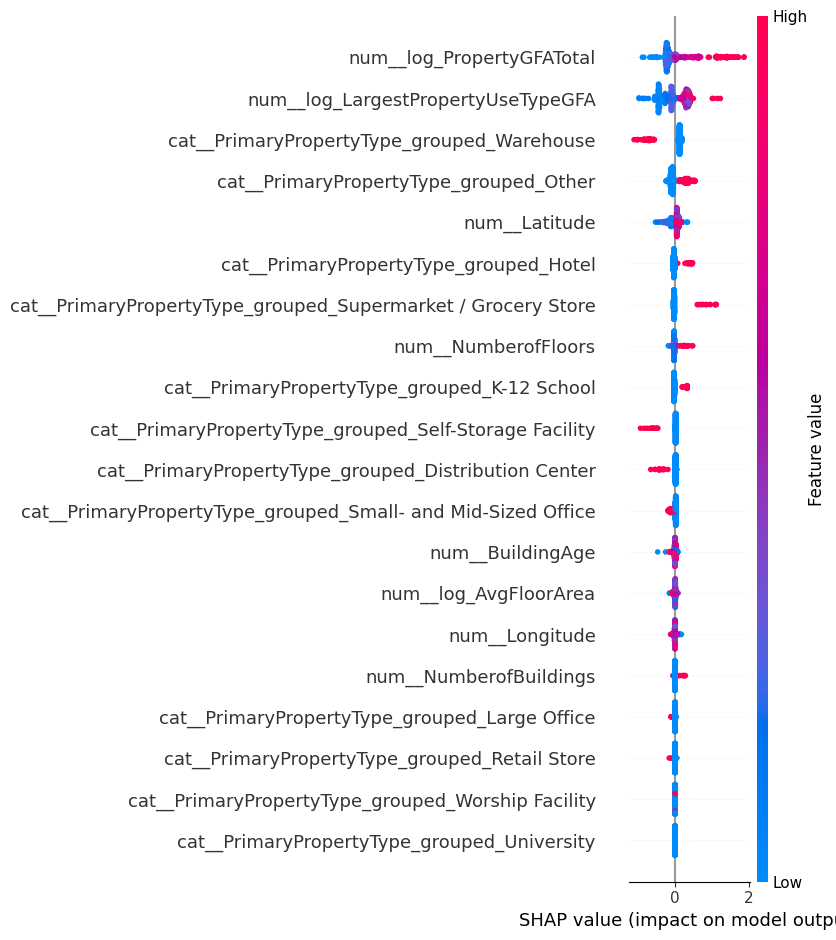

In [20]:
# 1. Récupérer le préprocesseur et le modèle final entraînés depuis votre pipeline
preprocessor = gs_final.best_estimator_.named_steps['preprocessor']
final_model = gs_final.best_estimator_.named_steps['model']

# 2. Transformer les données d'entraînement pour que SHAP comprenne les colonnes finales
X_train_transformed = preprocessor.transform(X_train)
# Récupérer les noms des colonnes après encodage pour les graphiques
feature_names = preprocessor.get_feature_names_out()

# 3. Créer un "explainer" SHAP
# Pour les modèles en arbres comme GradientBoosting, TreeExplainer est le plus efficace
explainer = shap.TreeExplainer(final_model)

# 4. Calculer les valeurs SHAP sur les données transformées
print("Calcul des valeurs SHAP...")
shap_values = explainer.shap_values(X_train_transformed)
print("Calcul terminé.")

# 5. Visualiser l'importance globale avec un "summary plot"
print("Importance Globale des Variables")
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


--- Génération du graphique des features les plus importantes ---


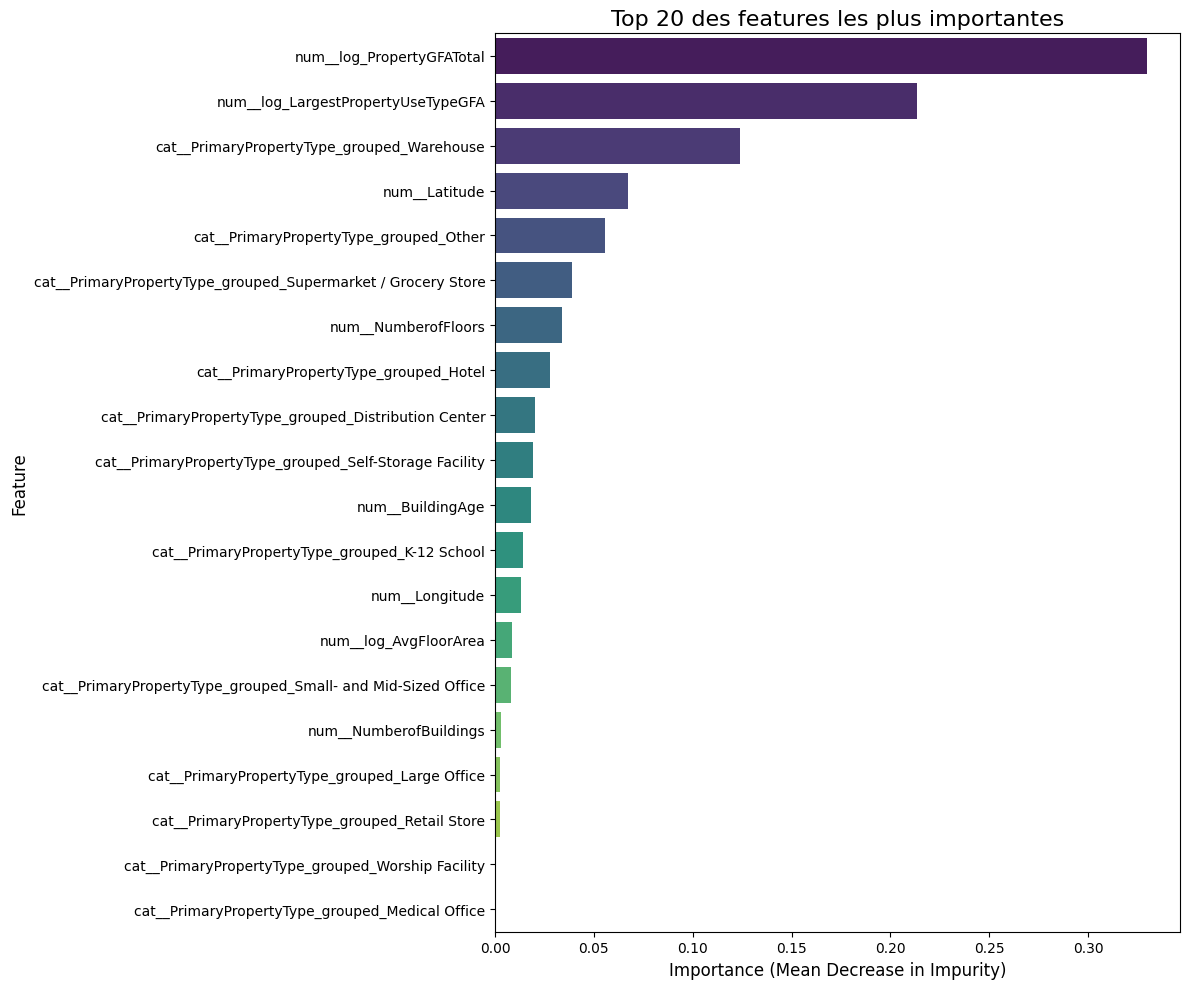

In [26]:
# 1. Extraire les noms des features APRÈS transformation
feature_names = final_optimized_model.named_steps['preprocessor'].get_feature_names_out()

# 2. Extraire les scores d'importance du modèle
importances = final_optimized_model.named_steps['model'].feature_importances_

# 3. Créer un DataFrame pour visualiser le tout
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# --- NOUVELLE PARTIE : GÉNÉRATION DU GRAPHIQUE ---

print("\n--- Génération du graphique des features les plus importantes ---")

# On sélectionne les 20 features les plus importantes pour garder le graphique lisible
top_20_features = feature_importance_df.head(20)

# On crée la figure
plt.figure(figsize=(12, 10))

# On utilise un graphique en barres horizontales (barplot) de seaborn
# C'est plus lisible quand les noms des features sont longs.
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')

# On ajoute des titres et des labels pour la clarté
plt.title('Top 20 des features les plus importantes', fontsize=16)
plt.xlabel('Importance (Mean Decrease in Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# On ajuste la mise en page pour que tout soit bien visible
plt.tight_layout()

# On affiche le graphique
plt.show()

La taille des bâtiments est le facteur dominant ici, la variable num__log_PropertyGFATotal (la surface totale du bâtiment) est de loin la plus importante.

Une valeur élevée (points rouges) a un fort impact positif (SHAP value > 0), ce qui augmente la prédiction (probablement la consommation d'énergie).

Une valeur faible (points bleus) a un impact négatif, ce qui diminue la prédiction.

La variable num__log_LargestPropertyUseTypeGFA (surface du plus grand type d'usage) a un effet similaire et est la deuxième plus importante.

Le type de propriété a un impact clair :

Être un entrepôt (_Warehouse) ou un hôtel (_Hotel) a tendance à augmenter la prédiction.

À l'inverse, être un bureau (_Small- and Mid-Sized Office) ou un lieu de culte (_Worship Facility) a tendance à diminuer la prédiction.

Influence géographique : La latitude (num__Latitude) a un impact notable.

Les latitudes plus élevées (points rouges, plus au nord) augmentent la prédiction, ce qui pourrait correspondre à un besoin de chauffage plus important.

En résumé, le modèle se base principalement sur la taille du bâtiment pour faire ses prédictions. Ensuite, le type de propriété et la localisation géographique viennent affiner le résultat. Le modèle semble suivre une logique cohérente.

Analyse de l'importance "locale" - zoom sur les bâtiments en particulier

In [ ]:


# 1. Extraire les noms des features APRÈS transformation
feature_names = final_optimized_model.named_steps['preprocessor'].get_feature_names_out()

# 2. Extraire les scores d'importance du modèle
importances = final_optimized_model.named_steps['model'].feature_importances_

# 3. Créer un DataFrame pour visualiser le tout
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# 4. Afficher les 15 features les plus importantes
print("--- Importance Globale des Features (selon le modèle) ---")
print(feature_importance_df.head(25))




--- Importance Globale des Features (selon le modèle) ---
                                              Feature  Importance
0                           num__log_PropertyGFATotal    0.329999
1                  num__log_LargestPropertyUseTypeGFA    0.213386
20         cat__PrimaryPropertyType_grouped_Warehouse    0.123751
6                                       num__Latitude    0.067298
13             cat__PrimaryPropertyType_grouped_Other    0.055604
18  cat__PrimaryPropertyType_grouped_Supermarket /...    0.038987
4                                 num__NumberofFloors    0.033699
9              cat__PrimaryPropertyType_grouped_Hotel    0.027848
8   cat__PrimaryPropertyType_grouped_Distribution ...    0.020128
16  cat__PrimaryPropertyType_grouped_Self-Storage ...    0.019067
3                                    num__BuildingAge    0.018153
10       cat__PrimaryPropertyType_grouped_K-12 School    0.014236
7                                      num__Longitude    0.013238
2                 

In [ ]:
batiments_a_analyser = {}

# Sélection par Type de Bâtiment ---

colonne_type = 'PrimaryPropertyType_grouped' 

types_a_chercher = ['Warehouse', 'Hotel', 'Small- and Mid-Sized Office']
for type_batiment in types_a_chercher:
    selection = X_test[X_test[colonne_type] == type_batiment]
    if not selection.empty:
        # On prend le premier bâtiment trouvé pour ce type
        batiments_a_analyser[type_batiment] = selection.index[0]

# Sélection par Taille (Surface) ---

colonne_surface = 'log_PropertyGFATotal'
batiments_a_analyser['Le plus grand'] = X_test[colonne_surface].idxmax()
batiments_a_analyser['Le plus petit'] = X_test[colonne_surface].idxmin()

# Sélection par Zone Géographique (Latitude) ---
colonne_latitude = 'Latitude'
batiments_a_analyser['Le plus au nord'] = X_test[colonne_latitude].idxmax()
batiments_a_analyser['Le plus au sud'] = X_test[colonne_latitude].idxmin()


# On affiche les bâtiments sélectionnés avec leur index
print("Bâtiments sélectionnés pour l'analyse locale :")
print(batiments_a_analyser)

Bâtiments sélectionnés pour l'analyse locale :
{'Warehouse': np.int64(361), 'Hotel': np.int64(10), 'Small- and Mid-Sized Office': np.int64(158), 'Le plus grand': np.int64(649), 'Le plus petit': np.int64(665), 'Le plus au nord': np.int64(108), 'Le plus au sud': np.int64(278)}


Étape 2: Génération des graphiques pour l'échantillon représentatif...

--- Analyse pour le cas : 'Warehouse' (Index du bâtiment : 361) ---


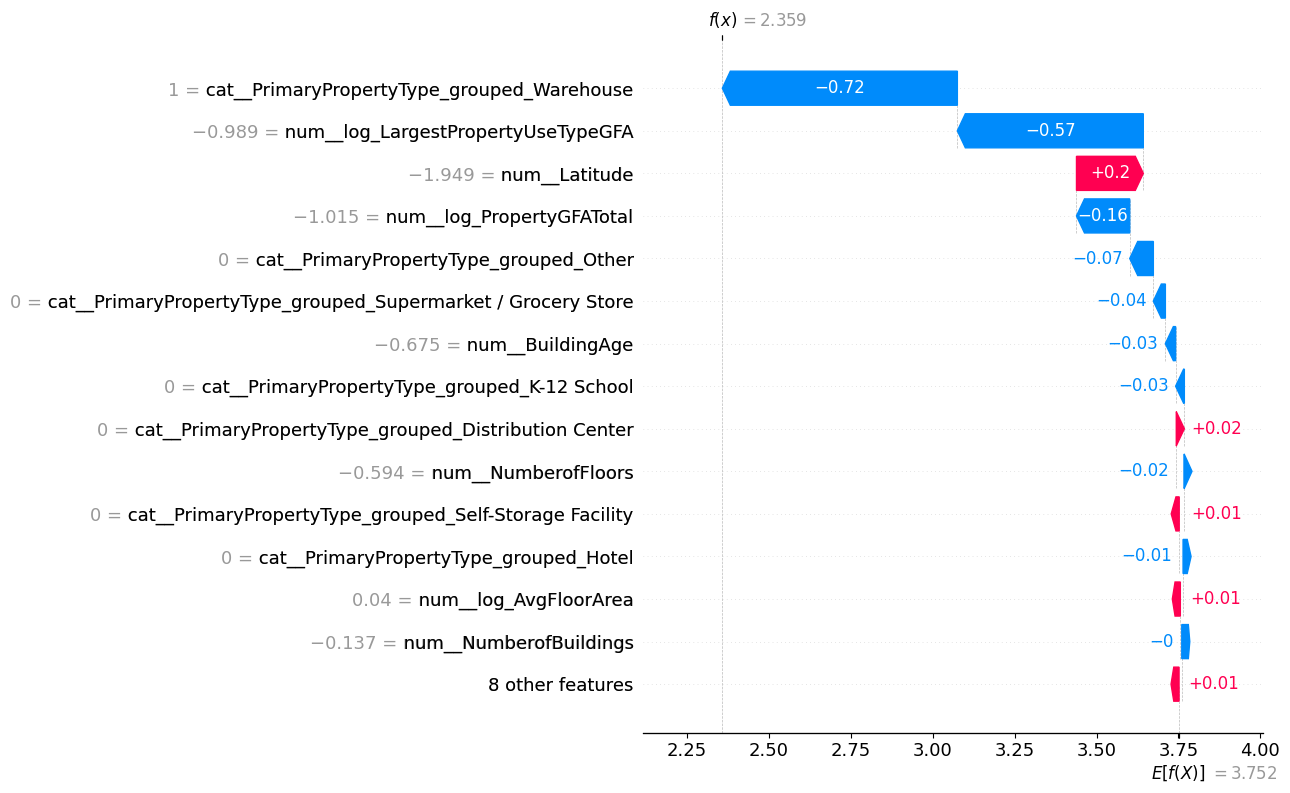


--- Analyse pour le cas : 'Hotel' (Index du bâtiment : 10) ---


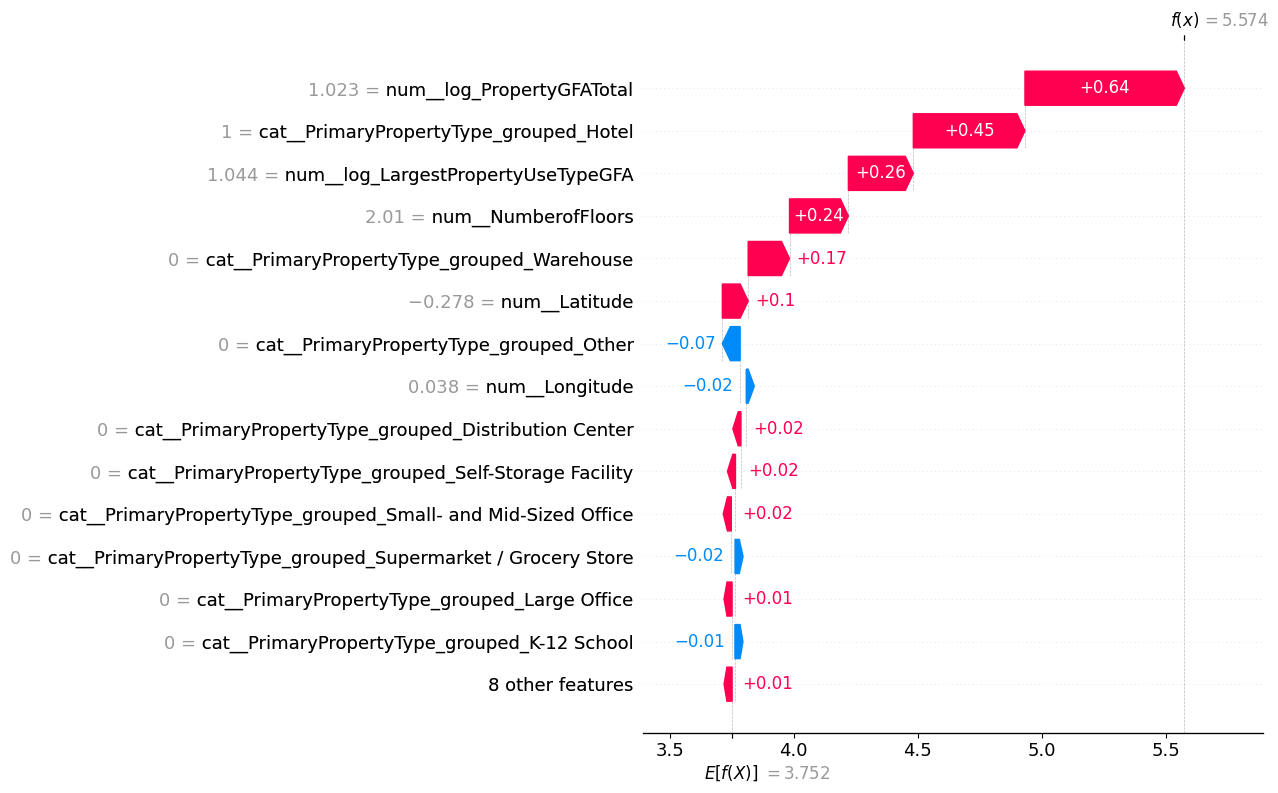


--- Analyse pour le cas : 'Small- and Mid-Sized Office' (Index du bâtiment : 158) ---


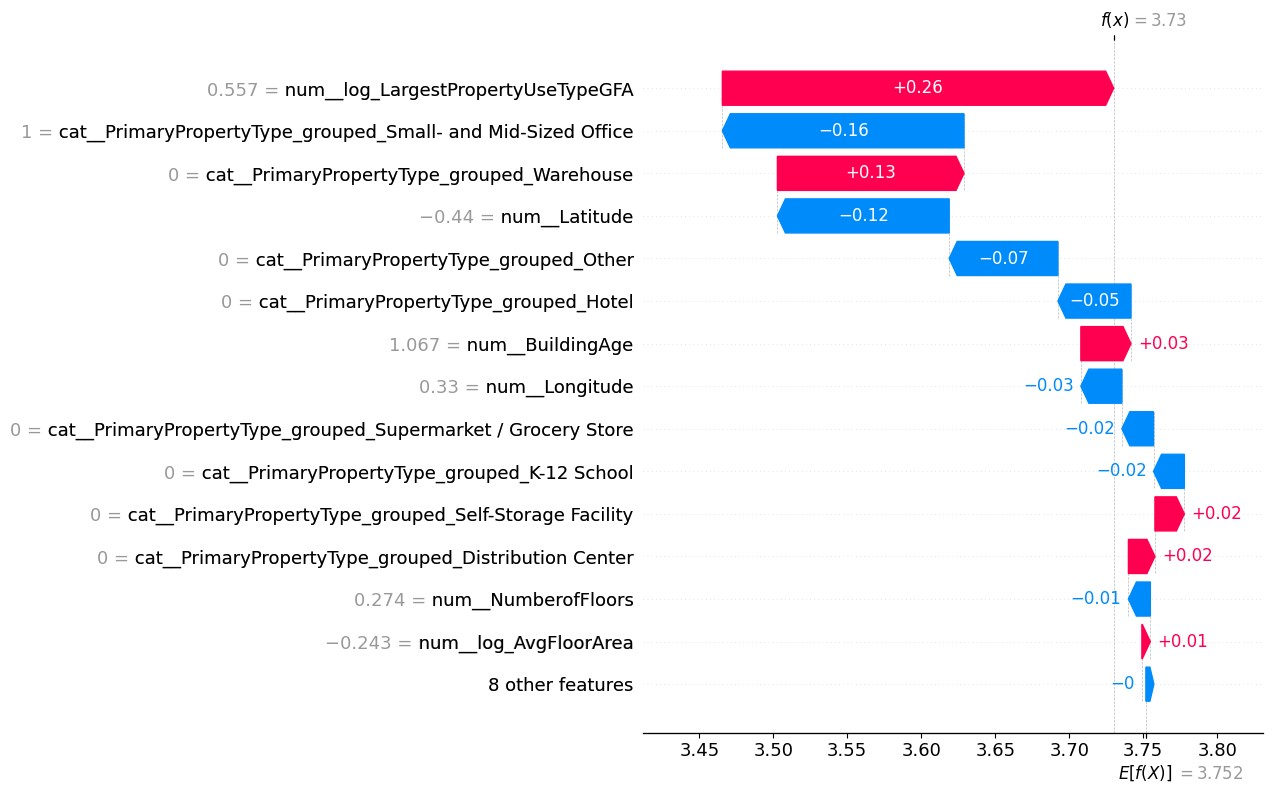


--- Analyse pour le cas : 'Le plus grand' (Index du bâtiment : 649) ---


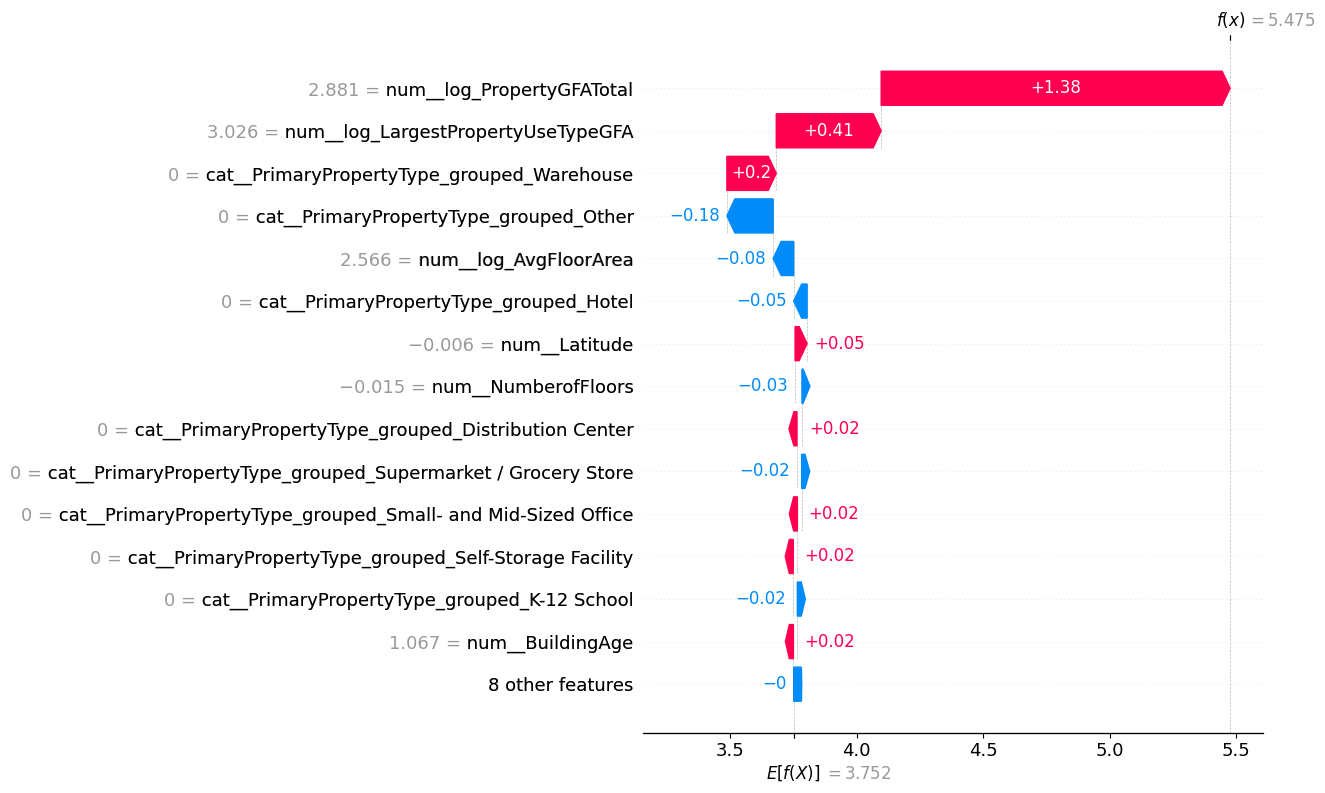


--- Analyse pour le cas : 'Le plus petit' (Index du bâtiment : 665) ---


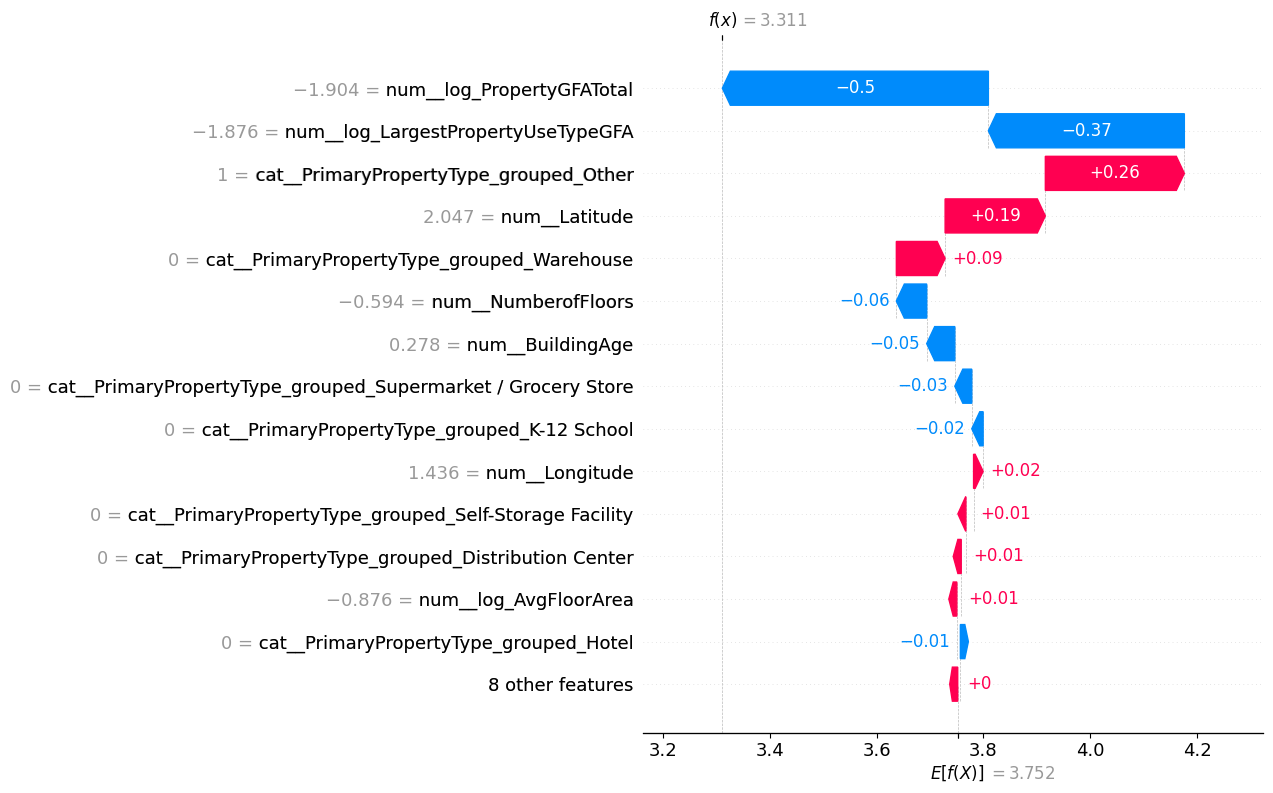


--- Analyse pour le cas : 'Le plus au nord' (Index du bâtiment : 108) ---


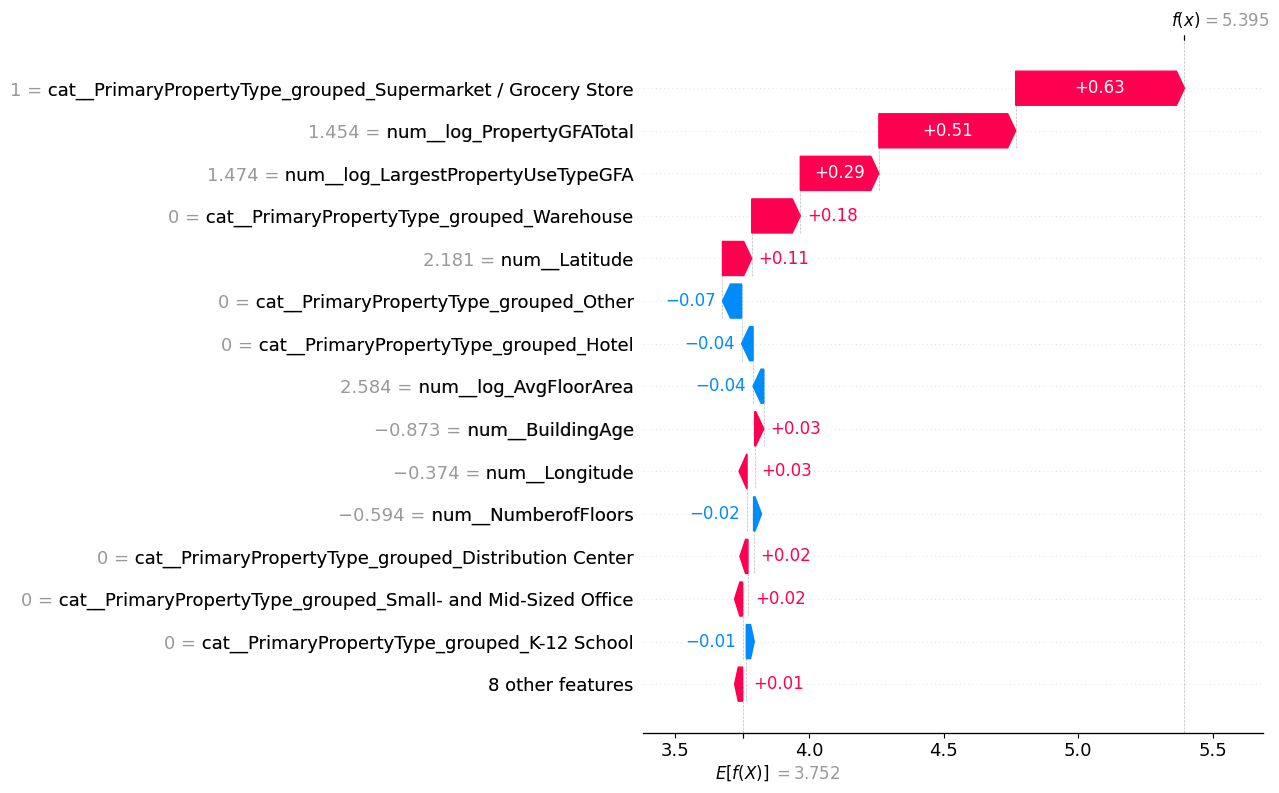


--- Analyse pour le cas : 'Le plus au sud' (Index du bâtiment : 278) ---


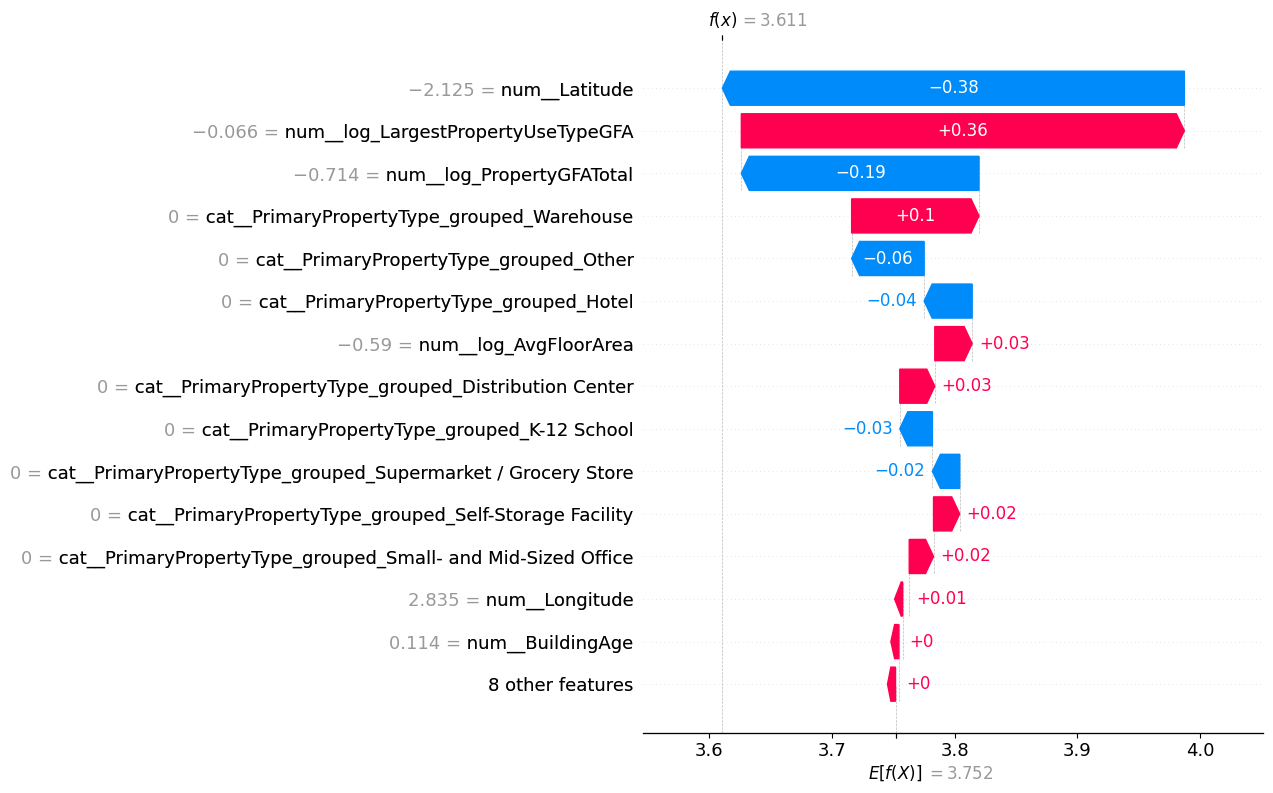

In [ ]:

preprocessor = final_optimized_model.named_steps['preprocessor']
model = final_optimized_model.named_steps['model']

# Transformer les données de test et récupérer les noms des nouvelles features
X_test_transformed = preprocessor.transform(X_test)
feature_names_out = preprocessor.get_feature_names_out()

# Créer un DataFrame des données transformées (étape cruciale pour éviter les erreurs)
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names_out,
    index=X_test.index
)

# Créer l'explainer et calculer les valeurs SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed_df)

## GÉNÉRER LES EXPLICATIONS POUR L'ÉCHANTILLON

print("Étape 2: Génération des graphiques pour l'échantillon représentatif...")

 #On boucle sur chaque bâtiment sélectionné dans le dictionnaire
for nom_cas, idx in batiments_a_analyser.items():
    
    print(f"\n--- Analyse pour le cas : '{nom_cas}' (Index du bâtiment : {idx}) ---")
    
    # Le waterfall_plot a besoin d'un objet "Explanation" spécifique.
    # On le crée pour chaque cas individuel.
    explanation_cas = shap.Explanation(
        values=shap_values[X_test.index.get_loc(idx)],
        base_values=explainer.expected_value,
        data=X_test_transformed_df.loc[idx],
        feature_names=X_test_transformed_df.columns.tolist()
    )
    
    # On génère le graphique waterfall, en affichant les 15 features les plus importantes
    shap.waterfall_plot(explanation_cas, max_display=15)

    # Le modèle prédit des émissions faibles pour ce bâtiment car il est minuscule. 
    # Cependant, ses émissions ne sont pas aussi basses qu'on pourrait le penser, car son type de propriété ('Autre') 
    # et sa localisation au nord sont deux facteurs qui, eux, augmentent les émissions.
    
    #explication sur l'hôtel :Le modèle prédit des émissions très élevées pour ce bâtiment 
    # car c'est un grand hôtel avec de nombreux étages. Toutes ses caractéristiques principales (taille, type et structure) 
    # sont des indicateurs forts d'émissions élevées

Analyse du modèle avec l'ajout de la variable EnergyStarScore

In [ ]:
#EXPÉRIENCE FINALE : Impact de l'ENERGYSTARScore - A REPRENDRE
# 1. Définir la nouvelle liste de features ayant un score energystar
df_star = pd.read_csv('clean_seattle.csv')
df_subset = df_star.dropna(subset=['ENERGYSTARScore']).copy()

features_avec_score = features_finales + ['ENERGYSTARScore']

# 2. Créer les nouveaux X et y
X_final_test = df_engineered[features_avec_score]
y_final_test = df_engineered[target] 

# 3. Séparer en train/test
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    X_final_test, y_final_test, test_size=0.2, random_state=42
)

# 4. Entraîner et évaluer le meilleur modèle optimisé sur ces nouvelles données
# on utilise ici gs_final.best_estimator_ qui est le meilleur pipeline
final_model_with_score = gs_final.best_estimator_
final_model_with_score.fit(X_train_score, y_train_score)
score_avec_score = final_model_with_score.score(X_test_score, y_test_score)

print(f"Score R² SANS ENERGYSTARScore : {final_r2_score:.4f}") # Le score de l'étape précédente
print(f"Score R² AVEC ENERGYSTARScore : {score_avec_score:.4f}")




Score R² SANS ENERGYSTARScore : 0.4407
Score R² AVEC ENERGYSTARScore : 0.4407


L'expérimentation finale visait à évaluer l'apport de la variable ENERGYSTARScore.   
De manière instructive, les résultats montrent que son ajout au modèle optimisé n'a eu aucun impact sur la performance, le score R² restant inchangé à 0.4407.  

Cette conclusion forte suggère que les autres variables du modèle, notamment la surface, le type et la localisation du bâtiment, capturent déjà l'intégralité de l'information prédictive contenue dans le score ENERGY STAR.   
Pour ce modèle, cette variable est donc redondante. Le modèle final retenu est par conséquent le GradientBoosting optimisé, sans l'ajout de cette variable.  
